# Visualize data

In order to start making interpretations we will generate two visualizations of our data

1. We will verify that the simulated dataset is a good representation of our original input dataset by visually comparing the structures in the two datasets projected onto UMAP space.

2. We will plot the PCA projected data after adding experiments to examine how the technical variation shifted the data.

3. We plot the PCA projected data after correcting for the technical variation introduced by the experiments and examine the effectiveness of the correction method by comparing the data before and after the correction.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import ast
import pandas as pd
import numpy as np
import random
import glob
from plotnine import ggplot, ggtitle, xlab, ylab, geom_point, aes, facet_wrap, scale_color_manual, xlim, ylim, scale_color_brewer 
from sklearn.decomposition import PCA
from keras.models import load_model
import umap

import warnings
warnings.filterwarnings(action='ignore')

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# User parameters
NN_architecture = 'NN_2500_30'
analysis_name = 'analysis_1'

In [3]:
# Load data

# base dir on repo
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))          

# base dir on local machine for data storage
# os.makedirs doesn't recognize `~`
local_dir = os.path.abspath(os.path.join(os.getcwd(), "../../../.."))  
    
latent_dim = NN_architecture.split('_')[-1]

NN_dir = base_dir + "/models/" + NN_architecture

normalized_data_file = os.path.join(
    base_dir,
    "data",
    "input",
    "train_set_normalized.pcl")

model_encoder_file = glob.glob(os.path.join( ## Make more explicit name here
    NN_dir,
    "tybalt_2layer_{}latent_encoder_model.h5".format(latent_dim)))[0]

weights_encoder_file = glob.glob(os.path.join(
    NN_dir,
    "tybalt_2layer_{}latent_encoder_weights.h5".format(latent_dim)))[0]

model_decoder_file = glob.glob(os.path.join(
    NN_dir,
    "tybalt_2layer_{}latent_decoder_model.h5".format(latent_dim)))[0]

weights_decoder_file = glob.glob(os.path.join(
    NN_dir,
    "tybalt_2layer_{}latent_decoder_weights.h5".format(latent_dim)))[0]

experiment_dir = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "experiment_simulated",
    analysis_name)

simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "simulated_data.txt.xz")

permuted_simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "permuted_simulated_data.txt.xz")

## Visualize simulated data (gene space) projected into UMAP space

In [4]:
# Load saved models
loaded_model = load_model(model_encoder_file)
loaded_decode_model = load_model(model_decoder_file)

loaded_model.load_weights(weights_encoder_file)
loaded_decode_model.load_weights(weights_decoder_file)

In [5]:
# Read data
normalized_data = pd.read_table(
    normalized_data_file,
    header=0,
    sep='\t',
    index_col=0).T

simulated_data = pd.read_table(
    simulated_data_file,
    header=0,
    sep='\t',
    index_col=0)

print(normalized_data.shape)
print(simulated_data.shape)

(950, 5549)
(18, 5550)


In [6]:
normalized_data.head(10)

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,0.853357,0.725280,0.640617,0.811465,0.694460,0.533958,0.158865,0.889579,0.884945,0.176558,...,0.466871,0.702785,0.790965,0.893249,0.789939,0.164157,0.970470,0.887472,0.900484,0.880012
54375-4-05.CEL,0.778790,0.767873,0.614859,0.907865,0.398800,0.460849,0.113876,0.761351,0.801740,0.222709,...,0.352020,0.694387,0.733186,0.639074,0.681204,0.110301,0.619554,0.747656,0.749893,0.805374
AKGlu_plus_nt_7-8-09_s1.CEL,0.789155,0.729508,0.725913,0.718989,0.530160,0.466327,0.079507,0.731643,0.827707,0.241847,...,0.392405,0.700352,0.773422,0.791118,0.931585,0.172570,0.797148,0.753785,0.856253,0.811099
anaerobic_NO3_1.CEL,0.716320,0.585079,0.390211,0.193248,0.279456,0.301781,0.513547,0.342051,0.415668,0.125914,...,0.398308,0.419574,0.593955,0.527203,0.706524,0.205510,0.504767,0.105662,0.363409,0.544780
anaerobic_NO3_2.CEL,0.658015,0.592172,0.410331,0.245504,0.312028,0.305852,0.513499,0.336723,0.334226,0.162965,...,0.407801,0.478697,0.571460,0.473054,0.669643,0.155548,0.562927,0.049738,0.388931,0.548814
control1aerobic_Pae_G1a.CEL,0.365512,0.572967,0.417762,0.663096,0.424846,0.606590,0.378900,0.224257,0.161582,0.074461,...,0.491161,0.565151,0.595824,0.382989,0.352268,0.250905,0.362161,0.487777,0.729434,0.483384
control1_anaerobic_Pae_G1a.CEL,0.689254,0.723461,0.510094,0.801569,0.619374,0.937262,0.138600,0.298615,0.306533,0.032482,...,0.754845,0.711126,0.589279,0.542699,0.591066,0.421389,0.392671,0.686055,0.911163,0.585208
control2aerobic_Pae_G1a.CEL,0.353000,0.580626,0.302544,0.639624,0.281793,0.687343,0.462645,0.000000,0.107961,0.093163,...,0.466139,0.545104,0.487957,0.330583,0.419139,0.328478,0.298493,0.254059,0.588305,0.406311
control2_anaerobic_Pae_G1a.CEL,0.674305,0.680740,0.515478,0.747121,0.656701,0.910654,0.149744,0.262492,0.263528,0.019910,...,0.775338,0.653142,0.642205,0.550935,0.565532,0.458622,0.426767,0.701314,0.886074,0.556363
control3aerobic_Pae_G1a.CEL,0.399186,0.653977,0.328755,0.692895,0.482482,0.618446,0.308135,0.191401,0.201170,0.020375,...,0.560889,0.654797,0.493961,0.454766,0.464733,0.456465,0.348577,0.503229,0.718768,0.474649


In [7]:
simulated_data.head(10)

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,color_by
GSM591496.CEL,0.716,0.723,0.550,0.782,0.382,0.377,0.188,0.686,0.576,0.189,...,0.667,0.687,0.619,0.592,0.211,0.617,0.636,0.699,0.703,WT
GSM591601.CEL,0.672,0.695,0.525,0.744,0.378,0.393,0.205,0.661,0.564,0.194,...,0.633,0.648,0.583,0.570,0.240,0.582,0.610,0.690,0.686,WT
GSM591602.CEL,0.663,0.685,0.500,0.714,0.395,0.359,0.215,0.689,0.586,0.187,...,0.620,0.622,0.567,0.593,0.251,0.608,0.613,0.681,0.693,WT
GSM591603.CEL,0.561,0.635,0.412,0.648,0.261,0.336,0.334,0.534,0.386,0.188,...,0.506,0.523,0.439,0.437,0.284,0.519,0.413,0.548,0.588,WT
GSM591622.CEL,0.549,0.630,0.413,0.648,0.253,0.348,0.335,0.527,0.384,0.186,...,0.488,0.516,0.435,0.422,0.286,0.508,0.394,0.541,0.591,WT
GSM591623.CEL,0.595,0.655,0.444,0.683,0.273,0.354,0.329,0.564,0.416,0.185,...,0.523,0.553,0.457,0.447,0.278,0.513,0.440,0.569,0.610,WT
GSM591624.CEL,0.452,0.594,0.318,0.476,0.225,0.352,0.295,0.406,0.310,0.215,...,0.431,0.428,0.367,0.417,0.283,0.491,0.325,0.499,0.552,topA::TnM
GSM591625.CEL,0.435,0.588,0.309,0.461,0.218,0.349,0.300,0.380,0.296,0.219,...,0.412,0.425,0.348,0.399,0.277,0.468,0.313,0.494,0.557,topA::TnM
GSM591627.CEL,0.380,0.563,0.276,0.426,0.218,0.351,0.317,0.374,0.275,0.204,...,0.382,0.392,0.342,0.388,0.288,0.477,0.298,0.489,0.551,topA::TnM
GSM597216.CEL,0.379,0.543,0.303,0.461,0.254,0.337,0.285,0.417,0.291,0.202,...,0.457,0.387,0.364,0.406,0.292,0.499,0.346,0.499,0.546,topA::TnM


In [8]:
# Add labels to original normalized data
sample_ids = list(simulated_data.index)


normalized_data_label = normalized_data.copy()

normalized_data_label['color_by'] = 'Not in experiment'
normalized_data_label.loc[sample_ids, 'color_by'] = simulated_data['color_by']
normalized_data_label.loc[sample_ids].head(10)

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,color_by
GSM591496.CEL,0.758438,0.808715,0.626747,0.774033,0.514039,0.383739,0.343325,0.719577,0.541627,0.216560,...,0.671244,0.670357,0.767884,0.640626,0.151623,0.659674,0.643497,0.746590,0.707505,WT
GSM591601.CEL,0.702824,0.755786,0.537629,0.755608,0.462175,0.316667,0.308082,0.704596,0.558551,0.160684,...,0.653341,0.668257,0.686663,0.630709,0.182788,0.703150,0.649179,0.739723,0.728428,WT
GSM591602.CEL,0.776721,0.736631,0.582667,0.749297,0.486610,0.302209,0.323932,0.782628,0.807336,0.225348,...,0.560667,0.688716,0.699709,0.647261,0.163239,0.589900,0.649514,0.724675,0.696667,WT
GSM591603.CEL,0.650666,0.733063,0.484848,0.682237,0.404460,0.314539,0.461867,0.569701,0.396897,0.201233,...,0.533048,0.536321,0.565483,0.565437,0.290283,0.518061,0.411037,0.675788,0.625928,WT
GSM591622.CEL,0.667370,0.710359,0.466625,0.627510,0.389397,0.330307,0.557265,0.504433,0.340656,0.158090,...,0.480189,0.524795,0.570522,0.514418,0.238918,0.437085,0.393830,0.658838,0.614567,WT
GSM591623.CEL,0.703303,0.749701,0.526009,0.704871,0.407054,0.357865,0.485271,0.618986,0.439075,0.188449,...,0.526229,0.621310,0.642635,0.564579,0.223575,0.530952,0.480025,0.714338,0.673815,WT
GSM591624.CEL,0.506639,0.700595,0.248761,0.454164,0.362564,0.251894,0.380947,0.398016,0.319026,0.246813,...,0.593767,0.604794,0.354962,0.607041,0.178784,0.503754,0.432141,0.461649,0.577097,topA::TnM
GSM591625.CEL,0.476276,0.661588,0.293446,0.465292,0.284225,0.184891,0.302357,0.201593,0.273987,0.405352,...,0.516100,0.558197,0.261896,0.566213,0.221264,0.394161,0.366527,0.487899,0.624791,topA::TnM
GSM591627.CEL,0.446758,0.540456,0.178815,0.459814,0.440751,0.238687,0.374581,0.244855,0.343819,0.155709,...,0.572563,0.594427,0.343618,0.571924,0.310482,0.346236,0.375161,0.525812,0.622629,topA::TnM
GSM597216.CEL,0.451599,0.584390,0.000000,0.652519,0.216197,0.329142,0.251821,0.399490,0.445968,0.206830,...,0.639575,0.622143,0.436442,0.559951,0.251479,0.407406,0.486234,0.661128,0.654488,topA::TnM


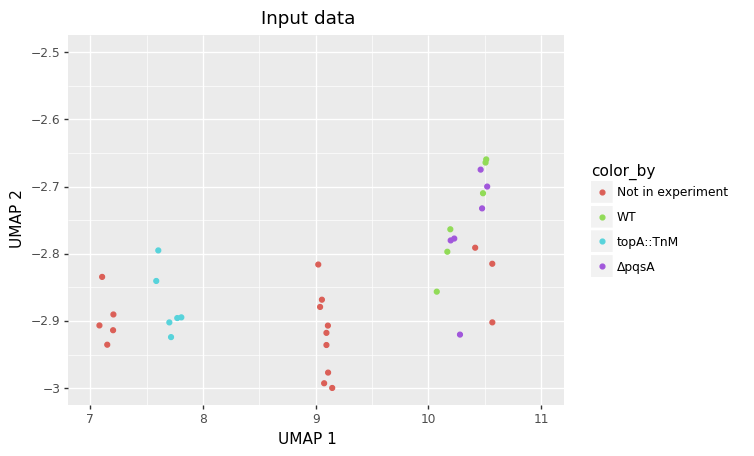

<ggplot: (8789277869916)>

In [28]:
# UMAP embedding of original input data

# Get and save model
model = umap.UMAP(random_state=randomState).fit(normalized_data)

input_data_UMAPencoded = model.transform(normalized_data)
input_data_UMAPencoded_df = pd.DataFrame(data=input_data_UMAPencoded,
                                         index=normalized_data.index,
                                         columns=['1','2'])
# Add label
input_data_UMAPencoded_df['color_by'] = normalized_data_label['color_by']

ggplot(input_data_UMAPencoded_df, aes(x='1',y='2')) \
    + geom_point(aes(color='color_by'), alpha=1) \
    + xlim(7, 11) \
    + ylim(-3, -2.5) \
    + xlab('UMAP 1') \
    + ylab('UMAP 2') \
    + ggtitle('Input data')

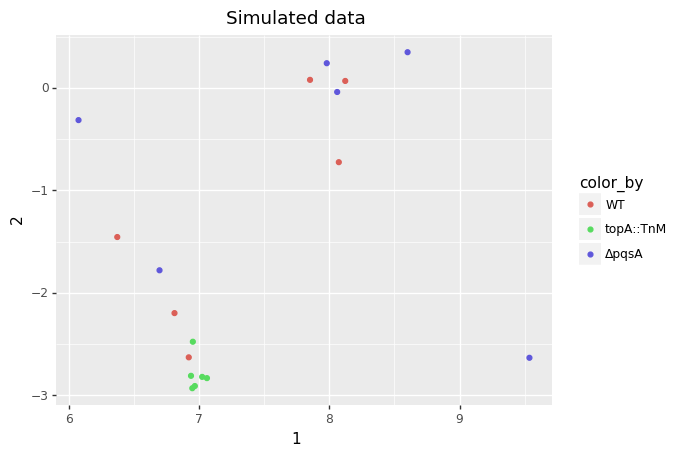

<ggplot: (8789206910384)>

In [11]:
# UMAP embedding of simulated data

# Drop label column
simulated_data_numeric = simulated_data.drop(['color_by'], axis=1)

simulated_data_UMAPencoded = model.transform(simulated_data_numeric)
simulated_data_UMAPencoded_df = pd.DataFrame(data=simulated_data_UMAPencoded,
                                         index=simulated_data.index,
                                         columns=['1','2'])

# Add back label column
simulated_data_UMAPencoded_df['color_by'] = simulated_data['color_by']


ggplot(simulated_data_UMAPencoded_df, aes(x='1',y='2')) \
    + geom_point(aes(color='color_by'), alpha=1) \
    + xlab('UMAP 1') \
    + ylab('UMAP 2') \
    + ggtitle("Simulated data")

### Side by side view

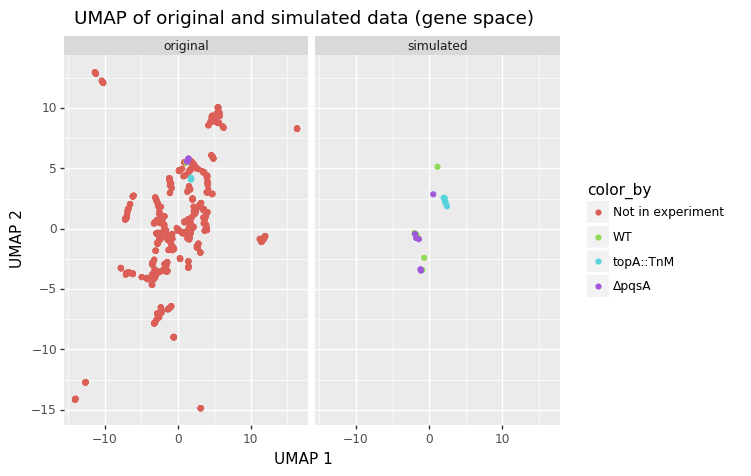

<ggplot: (8789278066054)>

In [20]:
# Add label for input or simulated dataset
input_data_UMAPencoded_df['dataset'] = 'original'
simulated_data_UMAPencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_UMAPencoded_df, simulated_data_UMAPencoded_df])

# Plot
ggplot(combined_data_df, aes(x='1', y='2')) \
+ geom_point(aes(color='color_by'), alpha=1) \
+ facet_wrap('~dataset') \
+ xlab('UMAP 1') \
+ ylab('UMAP 2') \
+ ggtitle('UMAP of original and simulated data (gene space)')

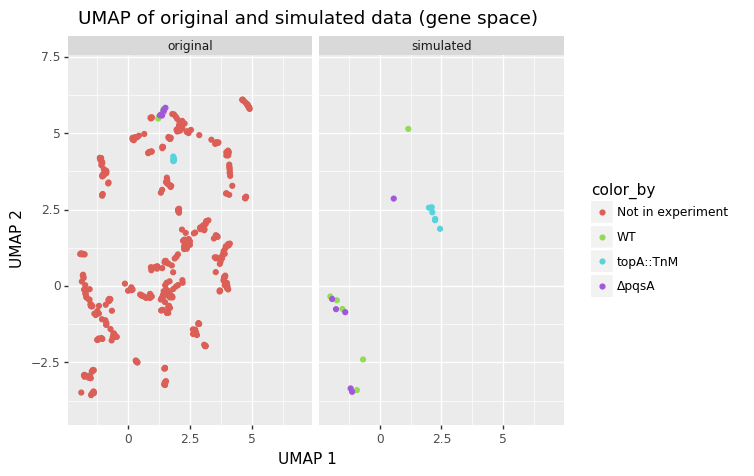

<ggplot: (8789277877431)>

In [27]:
# Zoomed in view

# Add label for input or simulated dataset
input_data_UMAPencoded_df['dataset'] = 'original'
simulated_data_UMAPencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_UMAPencoded_df, simulated_data_UMAPencoded_df])

# Plot
ggplot(combined_data_df, aes(x='1', y='2')) \
+ geom_point(aes(color='color_by'), alpha=1) \
+ facet_wrap('~dataset') \
+ xlab('UMAP 1') \
+ ylab('UMAP 2') \
+ xlim(-2, 7) \
+ ylim(-4, 7) \
+ ggtitle('UMAP of original and simulated data (gene space)')

## Visualize simulated data (gene space) projected into PCA space

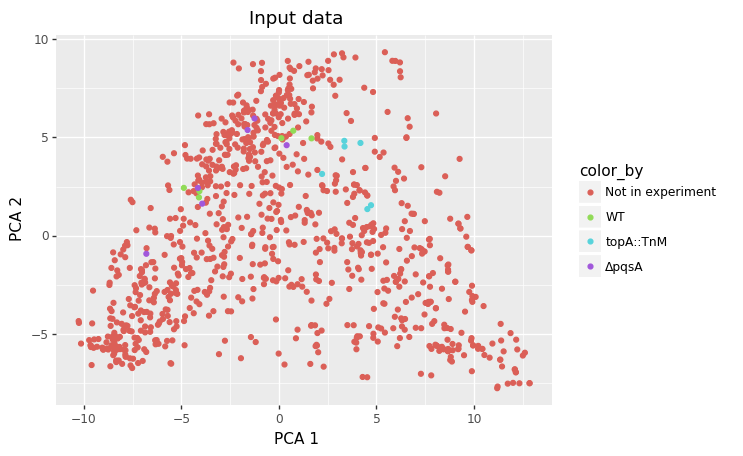

<ggplot: (-9223363247576885525)>

In [39]:
# UMAP embedding of original input data

# Get and save model
pca = PCA(n_components=2)
pca.fit(normalized_data)

input_data_PCAencoded = pca.transform(normalized_data)
input_data_PCAencoded_df = pd.DataFrame(data=input_data_PCAencoded,
                                         index=normalized_data.index,
                                         columns=['1','2'])
# Add label
input_data_PCAencoded_df['color_by'] = normalized_data_label['color_by']

ggplot(input_data_PCAencoded_df, aes(x='1',y='2')) \
    + geom_point(aes(color='color_by'), alpha=1) \
    + xlab('PCA 1') \
    + ylab('PCA 2') \
    + ggtitle('Input data')

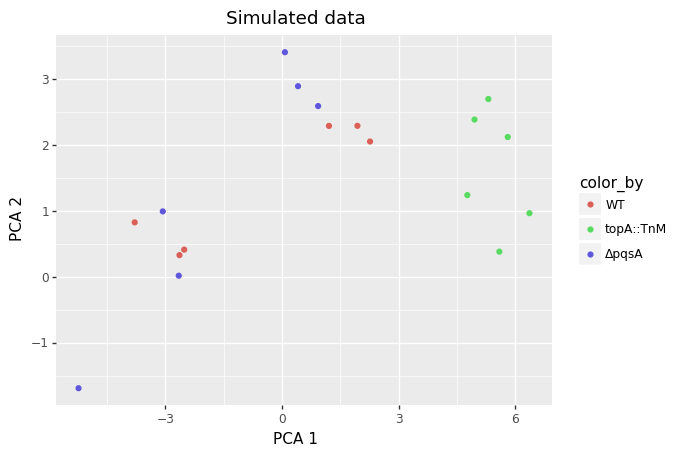

<ggplot: (-9223363247648693430)>

In [31]:
# UMAP embedding of simulated data

# Drop label column
simulated_data_numeric = simulated_data.drop(['color_by'], axis=1)

simulated_data_PCAencoded = pca.transform(simulated_data_numeric)
simulated_data_PCAencoded_df = pd.DataFrame(data=simulated_data_PCAencoded,
                                         index=simulated_data.index,
                                         columns=['1','2'])

# Add back label column
simulated_data_PCAencoded_df['color_by'] = simulated_data['color_by']


ggplot(simulated_data_PCAencoded_df, aes(x='1',y='2')) \
    + geom_point(aes(color='color_by'), alpha=1) \
    + xlab('PCA 1') \
    + ylab('PCA 2') \
    + ggtitle("Simulated data")

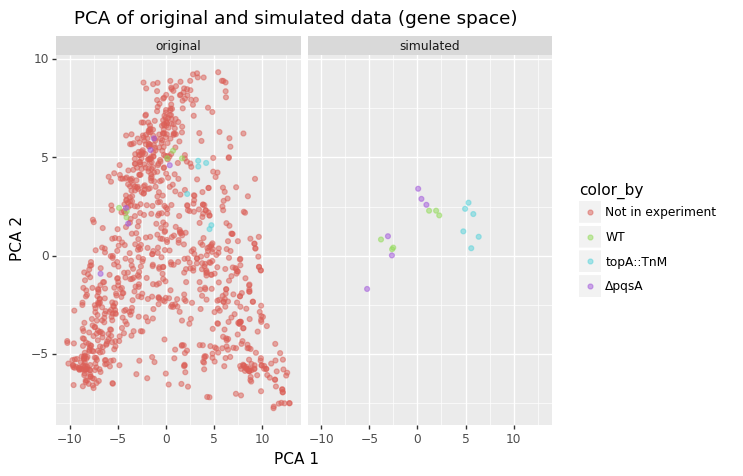

<ggplot: (8789278039318)>

In [33]:
# Add label for input or simulated dataset
input_data_PCAencoded_df['dataset'] = 'original'
simulated_data_PCAencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_PCAencoded_df, simulated_data_PCAencoded_df])

# Plot
ggplot(combined_data_df, aes(x='1', y='2')) \
+ geom_point(aes(color='color_by'), alpha=0.5) \
+ facet_wrap('~dataset') \
+ xlab('PCA 1') \
+ ylab('PCA 2') \
+ ggtitle('PCA of original and simulated data (gene space)')

## Visualize simulated data (latent space) projected into UMAP space

In [14]:
# Encode original gene expression data into latent space
data_encoded_all = loaded_model.predict_on_batch(normalized_data)
data_encoded_all_df = pd.DataFrame(data_encoded_all, index=normalized_data.index)

data_encoded_all_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
05_PA14000-4-2_5-10-07_S2.CEL,0.422848,0.227143,0.000000,2.775478,0.099096,0.187345,0.0,0.913457,0.563591,5.852476,...,0.0,1.146069,1.128008,0.701732,0.302885,0.0,2.231433,5.592579,0.000000,0.000000
54375-4-05.CEL,1.963878,0.041680,0.019930,3.249997,0.618932,0.000000,0.0,0.000000,4.561747,0.075101,...,0.0,0.000000,0.580954,5.656328,1.081226,0.0,2.466176,3.195375,0.000000,0.169168
AKGlu_plus_nt_7-8-09_s1.CEL,0.000000,0.000000,0.661532,0.424172,4.541715,1.975567,0.0,0.000000,0.000000,5.828680,...,0.0,3.462385,0.507580,0.463046,0.000000,0.0,0.017512,2.657393,0.000000,1.626901
anaerobic_NO3_1.CEL,0.405673,1.504278,0.767638,0.322747,0.000000,7.268587,0.0,0.000000,0.000000,1.062386,...,0.0,1.098558,0.114665,0.770498,0.638446,0.0,0.000000,0.000000,0.039404,2.798199
anaerobic_NO3_2.CEL,0.580626,1.145869,1.115794,0.248105,0.000000,7.246096,0.0,0.000000,0.000000,1.582029,...,0.0,1.120361,0.000000,0.941950,0.694830,0.0,0.000000,0.000000,0.033820,2.735597


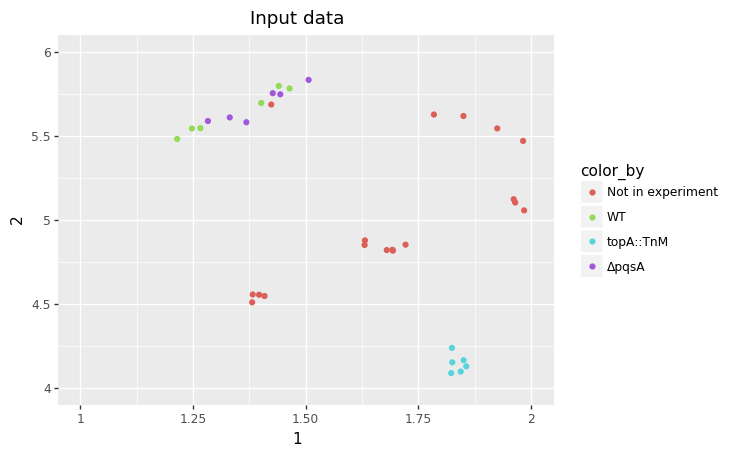

<ggplot: (-9223363247648655132)>

In [15]:
# Get and save model
model = umap.UMAP(random_state=randomState).fit(data_encoded_all_df)

input_data_UMAPencoded = model.transform(data_encoded_all_df)
input_data_UMAPencoded_df = pd.DataFrame(data=input_data_UMAPencoded,
                                         index=data_encoded_all_df.index,
                                         columns=['1','2'])
# Add label
input_data_UMAPencoded_df['color_by'] = normalized_data_label['color_by']

ggplot(input_data_UMAPencoded_df, aes(x='1',y='2')) \
    + geom_point(aes(color='color_by'), alpha=1) \
    + xlim(1,2) \
    + ylim(4,6) \
    + ggtitle('Input data')

In [16]:
# Encode simulated gene expression data into latent space
simulated_data_numeric = simulated_data.drop(['color_by'], axis=1)

simulated_data_encoded = loaded_model.predict_on_batch(simulated_data_numeric)
simulated_data_encoded_df = pd.DataFrame(simulated_data_encoded, index=simulated_data.index)

simulated_data_encoded_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
GSM591496.CEL,1.355231,0.000000,0.591704,0.253481,0.210982,1.651749,0.000000,0.000000,3.317852,1.554163,...,0.000000,0.213877,0.457007,4.019897,0.749911,0.0,0.697931,2.115459,0.000000,0.000000
GSM591601.CEL,1.342916,0.000000,0.486269,0.346731,0.455424,1.074934,0.000000,0.119791,2.763587,0.686682,...,0.000000,0.477880,0.720813,3.394576,0.631112,0.0,0.677836,1.887818,0.075349,0.000000
GSM591602.CEL,1.211189,0.000000,0.773796,0.173768,0.220082,1.709636,0.077388,0.180452,2.927420,1.320346,...,0.000000,0.560589,0.738990,1.984771,0.748652,0.0,0.505141,1.667562,0.118226,0.000000
GSM591603.CEL,0.911887,0.798662,0.509047,0.128838,0.000000,3.122568,0.000000,0.000000,0.254565,0.090198,...,0.481356,0.574437,0.860170,1.632830,1.374510,0.0,0.111073,0.090183,0.375732,0.036506
GSM591622.CEL,0.951629,0.852661,0.447482,0.141336,0.000000,2.941821,0.000000,0.000000,0.210705,0.000000,...,0.690815,0.623124,0.900876,1.601834,1.320741,0.0,0.075731,0.085820,0.441750,0.000000


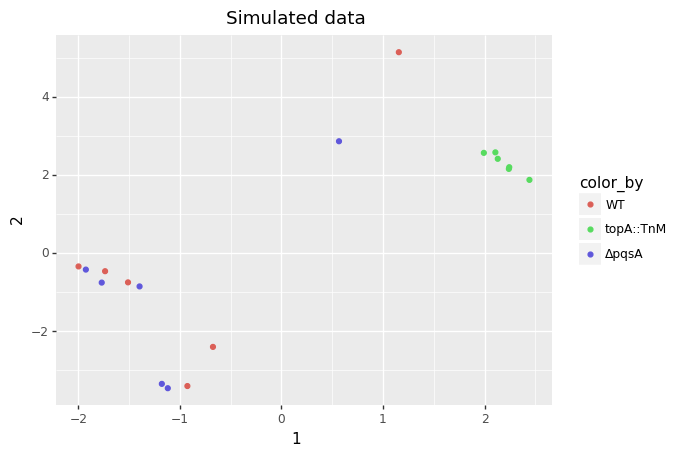

<ggplot: (-9223363247647944034)>

In [17]:
# Use same UMAP projection to plot simulated data
simulated_data_UMAPencoded = model.transform(simulated_data_encoded_df)
simulated_data_UMAPencoded_df = pd.DataFrame(data=simulated_data_UMAPencoded,
                                         index=simulated_data.index,
                                         columns=['1','2'])

# Add back label column
simulated_data_UMAPencoded_df['color_by'] = simulated_data['color_by']


ggplot(simulated_data_UMAPencoded_df, aes(x='1',y='2')) \
    + geom_point(aes(color='color_by'), alpha=1) \
    + ggtitle("Simulated data")

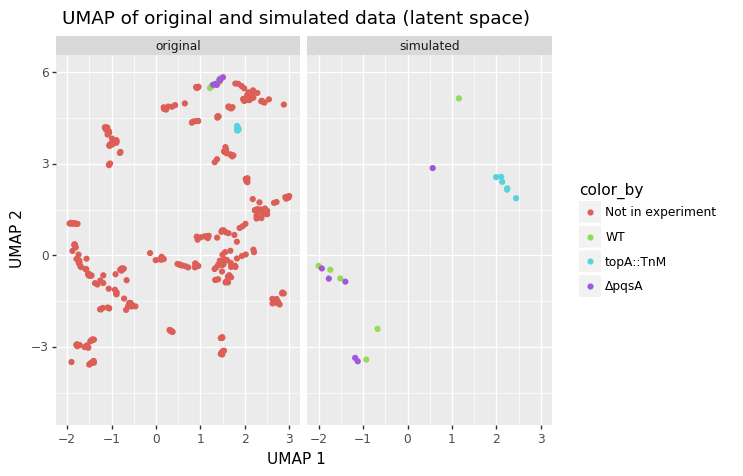

<ggplot: (8789197843888)>

In [19]:
# Zoomed in view

# Add label for input or simulated dataset
input_data_UMAPencoded_df['dataset'] = 'original'
simulated_data_UMAPencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_UMAPencoded_df, simulated_data_UMAPencoded_df])

# Plot
ggplot(combined_data_df, aes(x='1', y='2')) \
+ geom_point(aes(color='color_by'), alpha=1) \
+ facet_wrap('~dataset') \
+ xlab('UMAP 1') \
+ ylab('UMAP 2') \
+ xlim(-2, 3) \
+ ylim(-5,6) \
+ ggtitle('UMAP of original and simulated data (latent space)')

## Visualize simulated data (latent space) projected into PCA space

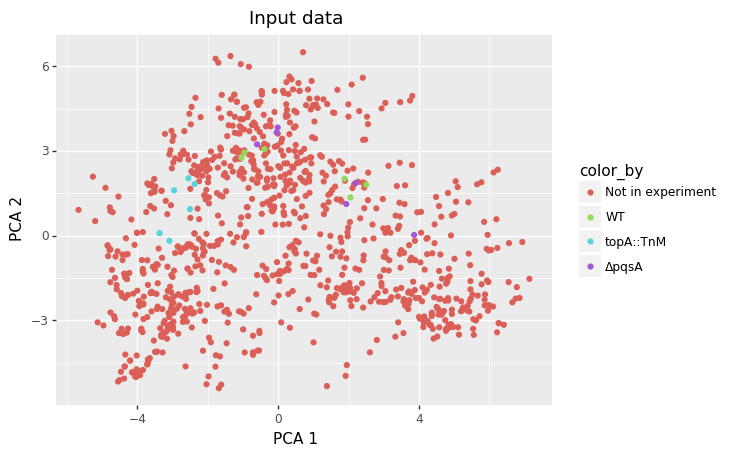

<ggplot: (8789277917160)>

In [35]:
# Get and save model
pca = PCA(n_components=2)
pca.fit(data_encoded_all_df)

input_data_PCAencoded = pca.transform(data_encoded_all_df)
input_data_PCAencoded_df = pd.DataFrame(data=input_data_PCAencoded,
                                         index=data_encoded_all_df.index,
                                         columns=['1','2'])
# Add label
input_data_PCAencoded_df['color_by'] = normalized_data_label['color_by']

ggplot(input_data_PCAencoded_df, aes(x='1',y='2')) \
    + geom_point(aes(color='color_by'), alpha=1) \
    + xlab('PCA 1') \
    + ylab('PCA 2') \
    + ggtitle('Input data')

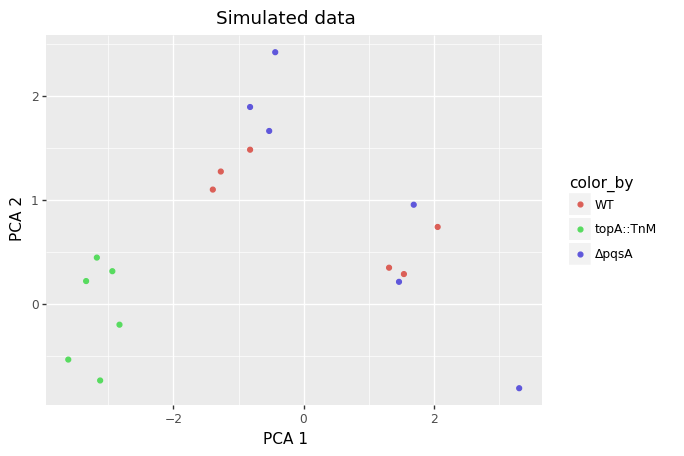

<ggplot: (-9223363247576781308)>

In [36]:
# Use same UMAP projection to plot simulated data
simulated_data_PCAencoded = pca.transform(simulated_data_encoded_df)
simulated_data_PCAencoded_df = pd.DataFrame(data=simulated_data_PCAencoded,
                                         index=simulated_data.index,
                                         columns=['1','2'])

# Add back label column
simulated_data_PCAencoded_df['color_by'] = simulated_data['color_by']


ggplot(simulated_data_PCAencoded_df, aes(x='1',y='2')) \
    + geom_point(aes(color='color_by'), alpha=1) \
    + xlab('PCA 1') \
    + ylab('PCA 2') \
    + ggtitle("Simulated data")

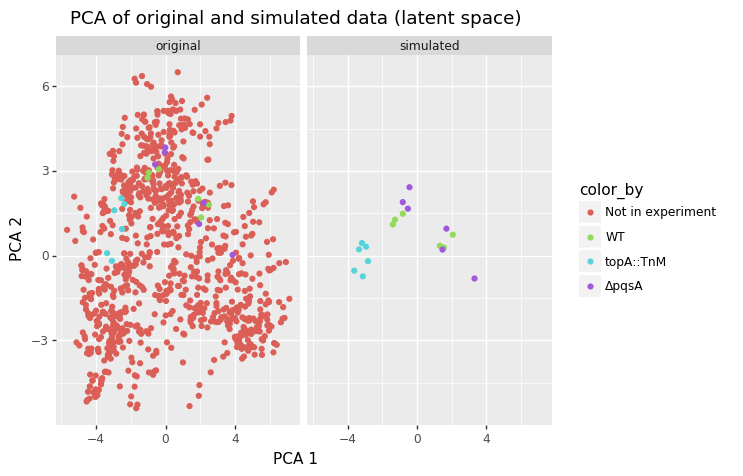

<ggplot: (8789277803454)>

In [38]:
# Zoomed in view

# Add label for input or simulated dataset
input_data_PCAencoded_df['dataset'] = 'original'
simulated_data_PCAencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_PCAencoded_df, simulated_data_PCAencoded_df])

# Plot
ggplot(combined_data_df, aes(x='1', y='2')) \
+ geom_point(aes(color='color_by'), alpha=1) \
+ facet_wrap('~dataset') \
+ xlab('PCA 1') \
+ ylab('PCA 2') \
+ ggtitle('PCA of original and simulated data (latent space)')